<a href="https://colab.research.google.com/github/gabrieladamasceno/Attacks_5G/blob/main/ORAN_Random_Forest_All_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Acessar dataset
drive.mount('/content/gdrive')

# Carregar o dataset
encoded = pd.read_csv("/content/gdrive/MyDrive/Datasets/Attacks/ORAN/Network_Dataset.csv")

Mounted at /content/gdrive


In [ ]:
import pandas as pd


print(f"Total de colunas: {len(encoded.columns)}\n")
print(encoded.columns.tolist())

Total de colunas: 26

['uid', 'src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'service', 'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes', 'history', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'ip_proto', 'http_trans_depth', 'attack_category', 'attack_type', 'files_total_bytes', 'is_GET_mthd', 'http_status_error', 'is_file_transfered', 'traffic_type']


In [ ]:
import pandas as pd

# Ver todos os tipos de ataque (categorias amplas)
print("Categorias de ataque:")
print(encoded['attack_category'].unique())

# Contar ocorrência de cada categoria
print("\nContagem por categoria:")
print(encoded['attack_category'].value_counts())

# Ver todos os tipos específicos de ataque
print("\nTipos específicos de ataque:")
print(encoded['attack_type'].unique())

# Contar ocorrência de cada tipo específico
print("\nContagem por tipo:")
print(encoded['attack_type'].value_counts())

Categorias de ataque:
['ddos' 'bruteforce' 'probe' 'web' 'dos' 'benign']

Contagem por categoria:
attack_category
dos           632507
ddos          420282
web           288304
probe         183293
benign        170865
bruteforce     28566
Name: count, dtype: int64

Tipos específicos de ataque:
['tcp_ack' 'syn' 'icmp' 'slowloris' 'udp' 'ssh' 'ftp' 'portscan_tcp'
 'os_fingerprinting' 'portscan_udp' 'http_flood' 'dir_bruteforce' 'benign'
 'xss' 'sql_injection']

Contagem por tipo:
attack_type
syn                  506451
http_flood           254314
udp                  227408
tcp_ack              199304
benign               170865
portscan_tcp         100000
slowloris             94887
os_fingerprinting     62957
dir_bruteforce        28566
icmp                  24739
portscan_udp          20336
ssh                   14902
ftp                   13664
xss                    3661
sql_injection          1763
Name: count, dtype: int64


In [ ]:
pip install imbalanced-learn


In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 106.3 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is in

In [ ]:
!pip install gputil


  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=2ba700e26167076d5455400395738bce5b7f7ea63f77f7846d8046b0f7349a9f
  Stored in directory: /root/.cache/pip/wheels/92/a8/b7/d8a067c31a74de9ca252bbe53dea5f896faabd25d55f541037
Successfully built gputil


In [ ]:
# Selecionar apenas colunas numéricas
numeric_cols = encoded.select_dtypes(include=['number']).columns

# Aplicar a suavização apenas nas colunas numéricas
for col in numeric_cols:
    encoded[col] = encoded[col].fillna(encoded[col].mean())

In [ ]:
# columns with null values

columns_null = []
columns = encoded.columns
for column in columns:
    c = encoded[column].isnull().sum()
    if c != 0:
        print(column, 'has {} null values'.format(c))
        columns_null.append(column)

In [ ]:
import psutil
import time
import numpy as np
import pandas as pd
import gc
import tensorflow as tf
import subprocess
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K

# ===== Função para monitorar CPU e memória =====
def monitor_resource_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    cpu_percent = psutil.cpu_percent(interval=0.1)
    memory_usage_mb = memory_info.rss / (1024 * 1024)
    return cpu_percent, memory_usage_mb

def calcular_energia(cpu_usage, freq_ghz, tempo_exec_s, theta=1.0, z=1e-27):
    freq_hz = freq_ghz * 1e9
    carga = cpu_usage * theta * freq_hz
    energia_joules = z * (carga ** 3) * tempo_exec_s
    return energia_joules

# ===== Callback para monitoramento durante o treinamento =====
class ResourceMonitor(Callback):
    def on_train_begin(self, logs=None):
        self.cpu_usage = []
        self.memory_usage = []
        self.energy_usage = []
        self.start_time = time.time()
        print("\n[Início do Treinamento]")

    def on_epoch_begin(self, epoch, logs=None):
        cpu, mem = monitor_resource_usage()
        self.cpu_usage.append(cpu)
        self.memory_usage.append(mem)
        print(f"\n[Epoch {epoch + 1} - Início] CPU: {cpu:.2f}%, Memory: {mem:.2f} MB")

    def on_epoch_end(self, epoch, logs=None):
        cpu, mem = monitor_resource_usage()
        self.cpu_usage.append(cpu)
        self.memory_usage.append(mem)
        frequencia_cpu_ghz = 2.0
        tempo_execucao_epoca = time.time() - self.start_time
        #energy = calcular_energia(cpu, frequencia_cpu_ghz, tempo_execucao_epoca)
        #self.energy_usage.append(energy)
        print(f"[Epoch {epoch + 1} - Fim] CPU: {cpu:.2f}%, Memory: {mem:.2f} MB")

        # Limpeza de recursos
        gc.collect()
        K.clear_session()

    def on_train_end(self, logs=None):
        total_time = time.time() - self.start_time
        avg_cpu = np.mean(self.cpu_usage)
        avg_mem = np.mean(self.memory_usage)

        frequencia_cpu_ghz = 2.0

        # Cálculo de energia corrigido
        energia = calcular_energia(avg_cpu, frequencia_cpu_ghz, total_time)

        print("\n[End of Training]")
        print(f"Total time: {total_time:.2f} seconds")
        print(f"Average CPU usage (Training): {avg_cpu:.2f}%")
        print(f"Average memory usage (Training): {avg_mem:.2f} MB")
        print(f"Estimated energy consumption: {energia:.2f} Joules")

        # Armazenar para uso externo
        self.total_time = total_time
        self.avg_cpu = avg_cpu
        self.avg_mem = avg_mem
        self.energia = energia

        self._plot_usage()

    def _plot_usage(self):
        epochs = list(range(1, len(self.cpu_usage) + 1))

        plt.figure(figsize=(14, 5))

        # CPU
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.cpu_usage, marker='o', linestyle='-', color='tab:blue', label='CPU Usage')
        plt.xlabel("Epoch")
        plt.ylabel("CPU Usage (%)")
        plt.title("CPU Consumption (Train)")
        plt.legend()
        plt.grid(True)

        # Memória
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.memory_usage, marker='o', linestyle='-', color='tab:red', label='Memory Usage')
        plt.xlabel("Epoch")
        plt.ylabel("Memory (MB)")
        plt.title("Memory Consumption (Train)")
        plt.legend()
        plt.grid(True)


        plt.tight_layout()
        plt.savefig("resource_usage_train.png")
        plt.show()
        plt.clf()
        plt.close()


# ===== Monitoramento durante o teste/predição =====
def monitor_test_prediction(model, X_test):
    cpu_usage_test = []
    memory_usage_test = []

    print("\n[Início da Predição/Teste]")
    start_time = time.time()

    step_size = max(1, len(X_test) // 10)
    for i in range(0, len(X_test), step_size):
        end_i = min(i + step_size, len(X_test))
        monitor_cpu, monitor_mem = monitor_resource_usage()
        cpu_usage_test.append(monitor_cpu)
        memory_usage_test.append(monitor_mem)
        _ = model.predict(X_test[i:end_i])

    total_time_test = time.time() - start_time
    avg_cpu_test = np.mean(cpu_usage_test)
    avg_mem_test = np.mean(memory_usage_test)

    frequencia_cpu_ghz = 2.0

    # Cálculo de energia
    energia_test = calcular_energia(avg_cpu_test, frequencia_cpu_ghz, total_time_test)

    print("\n[End of Prediction/Test]")
    print(f"Total time: {total_time_test:.2f} seconds")
    print(f"Average CPU usage (Test): {avg_cpu_test:.2f}%")
    print(f"Average memory usage (Test): {avg_mem_test:.2f} MB")
    print(f"Estimated energy consumption: {energia_test:.2f} Joules")

    # Gráficos
    plt.figure(figsize=(14, 5))

    # CPU
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(cpu_usage_test) + 1), cpu_usage_test, marker='o', linestyle='-', color='tab:blue', label='CPU Usage (Test)')
    plt.xlabel("Prediction Block")
    plt.ylabel("CPU Usage (%)")
    plt.title("CPU Consumption (Test)")
    plt.legend()
    plt.grid(True)

    # Memória
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(memory_usage_test) + 1), memory_usage_test, marker='o', linestyle='-', color='tab:red', label='Memory Usage (Test)')
    plt.xlabel("Prediction Block")
    plt.ylabel("Memory (MB)")
    plt.title("Memory Consumption (Test)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("resource_usage_test.png")
    plt.show()
    plt.clf()
    plt.close()

    return {
    'total_time': total_time_test,
    'avg_cpu': avg_cpu_test,
    'avg_mem': avg_mem_test,
    'energia': energia_test
    }

resource_monitor = ResourceMonitor()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [ ]:
def monitor_train_generic(model, X_train, y_train, model_name="model"):
    print(f"\n[Início do Treinamento - {model_name}]")
    process = psutil.Process(os.getpid())

    # Coleta inicial
    cpu_start = process.cpu_percent(interval=None)
    mem_start = process.memory_info().rss / (1024 * 1024)
    start_time = time.time()

    # Treinamento — funciona para sklearn, CatBoost etc.
    model.fit(X_train, y_train)

    # Coleta final
    cpu_end = process.cpu_percent(interval=None)
    mem_end = process.memory_info().rss / (1024 * 1024)
    end_time = time.time()

    total_time = end_time - start_time
    avg_cpu = (cpu_start + cpu_end) / 2
    avg_mem = (mem_start + mem_end) / 2
    freq_ghz = 2.0

    # Reaproveita sua função de energia
    energia = calcular_energia(avg_cpu, freq_ghz, total_time)

    print(f"[Fim do Treinamento - {model_name}]")
    print(f"Tempo total: {total_time:.2f}s")
    print(f"CPU média: {avg_cpu:.2f}%")
    print(f"Memória média: {avg_mem:.2f} MB")
    print(f"Energia estimada: {energia:.2e} Joules")

    return {
        'total_time': total_time,
        'avg_cpu': avg_cpu,
        'avg_mem': avg_mem,
        'energia': energia
    }

In [ ]:
print(encoded['traffic_type'].unique())

[1 0]


In [ ]:
# Criar label binária: 0 = benign, 1 = ataque
encoded['Label'] = encoded['traffic_type'].apply(lambda x: 0 if x == 0 else 1)

# Conferir
print(encoded[['traffic_type', 'Label']].head(10))
print("\nDistribuição das classes:")
print(encoded['Label'].value_counts())

   traffic_type  Label
0             1      1
1             1      1
2             1      1
3             1      1
4             1      1
5             1      1
6             1      1
7             1      1
8             1      1
9             1      1

Distribuição das classes:
Label
1    1552952
0     170865
Name: count, dtype: int64


In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.9 MB/s eta 0:00:00



====== Zero-Day: tcp_ack ======
Total tcp_ack no dataset original: 199304
  em X_train antes da remoção: 159722
  em X_test antes: 39582
  moved_to_test (vai mover): 159722
  test_zero (já no teste): 39582
  Zero-Day combined total: 199304 (duplicadas exatas: 1012)
  Test full total: 504486

[Início do Treinamento - Random Forest]
[Fim do Treinamento - Random Forest]
Tempo total: 406.90s
CPU média: 50.00%
Memória média: 2977.07 MB
Energia estimada: 4.07e+08 Joules

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 3.79 seconds
Average CPU usage (Test): 0.45%
Average memory usage (Test): 2993.79 MB
Estimated energy consumption: 2.85 Joules


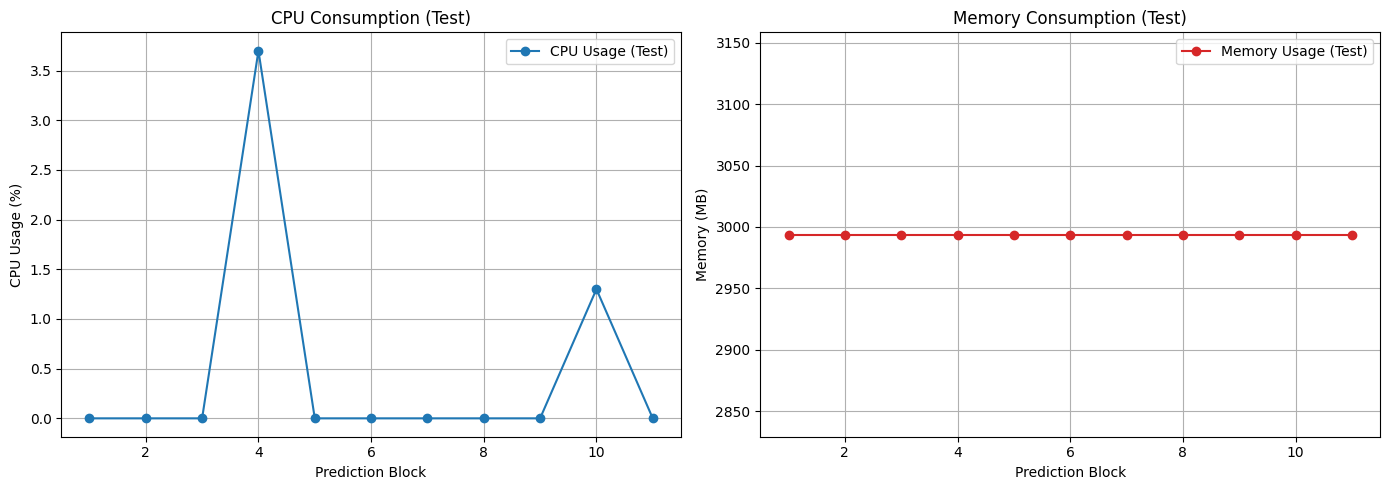


[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 2.14 seconds
Average CPU usage (Test): 14.24%
Average memory usage (Test): 2996.14 MB
Estimated energy consumption: 49309.96 Joules


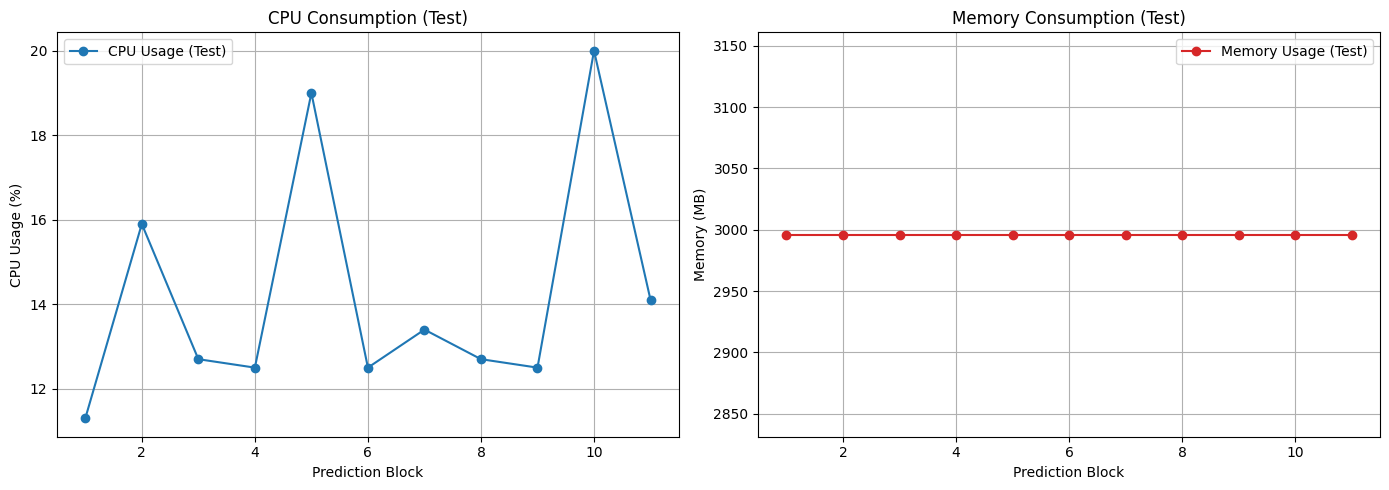

✅ Curva ROC (FULL) gerada para tcp_ack — AUC=0.9966

====== Zero-Day: syn ======
Total syn no dataset original: 506451
  em X_train antes da remoção: 405095
  em X_test antes: 101356
  moved_to_test (vai mover): 405095
  test_zero (já no teste): 101356
  Zero-Day combined total: 506451 (duplicadas exatas: 155400)
  Test full total: 749859

[Início do Treinamento - Random Forest]
[Fim do Treinamento - Random Forest]
Tempo total: 280.90s
CPU média: 50.00%
Memória média: 3095.14 MB
Energia estimada: 2.81e+08 Joules

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 4.86 seconds
Average CPU usage (Test): 0.55%
Average memory usage (Test): 3120.74 MB
Estimated energy consumption: 6.63 Joules


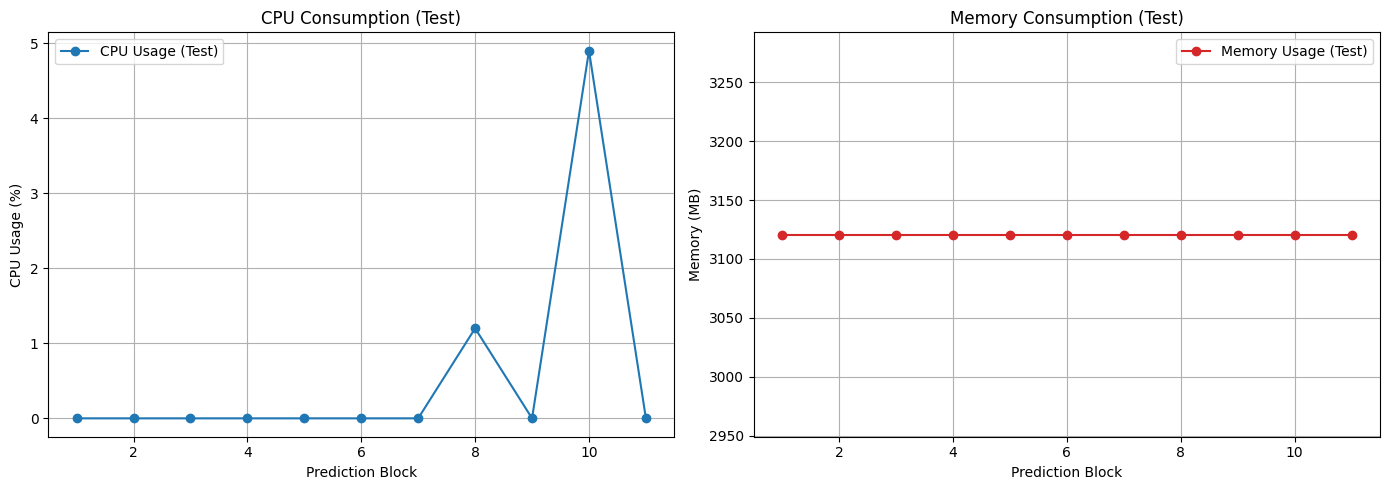


[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 3.45 seconds
Average CPU usage (Test): 5.14%
Average memory usage (Test): 3120.75 MB
Estimated energy consumption: 3740.57 Joules


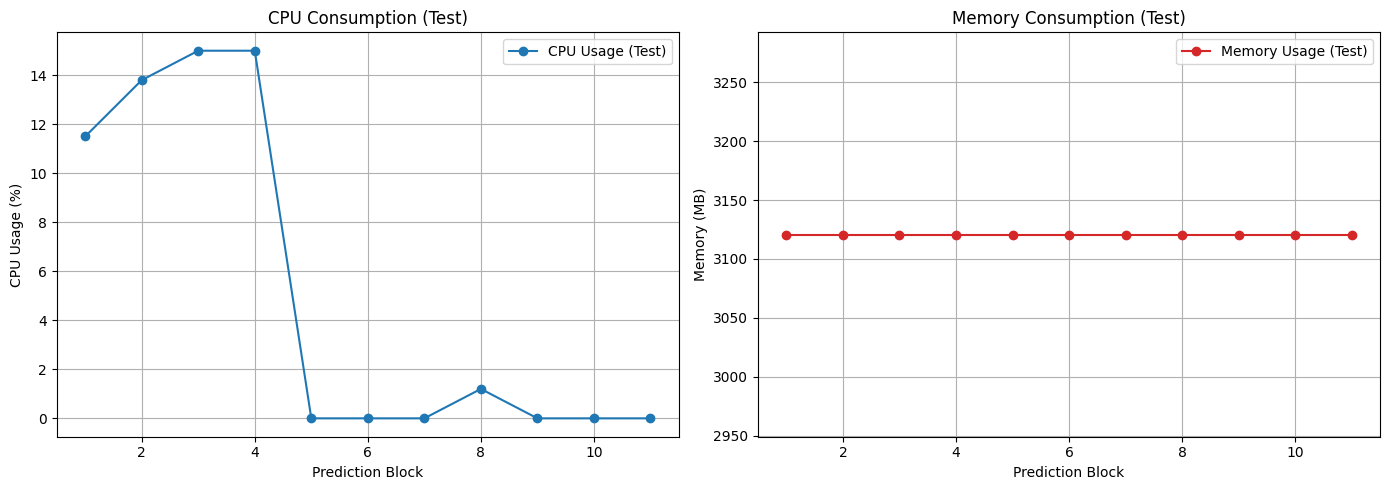

✅ Curva ROC (FULL) gerada para syn — AUC=0.9979

====== Zero-Day: icmp ======
Total icmp no dataset original: 24739
  em X_train antes da remoção: 19756
  em X_test antes: 4983
  moved_to_test (vai mover): 19756
  test_zero (já no teste): 4983
  Zero-Day combined total: 24739 (duplicadas exatas: 513)
  Test full total: 364520

[Início do Treinamento - Random Forest]
[Fim do Treinamento - Random Forest]
Tempo total: 289.21s
CPU média: 50.00%
Memória média: 3465.68 MB
Energia estimada: 2.89e+08 Joules

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 3.09 seconds
Average CPU usage (Test): 0.62%
Average memory usage (Test): 3465.73 MB
Estimated energy consumption: 5.89 Joules


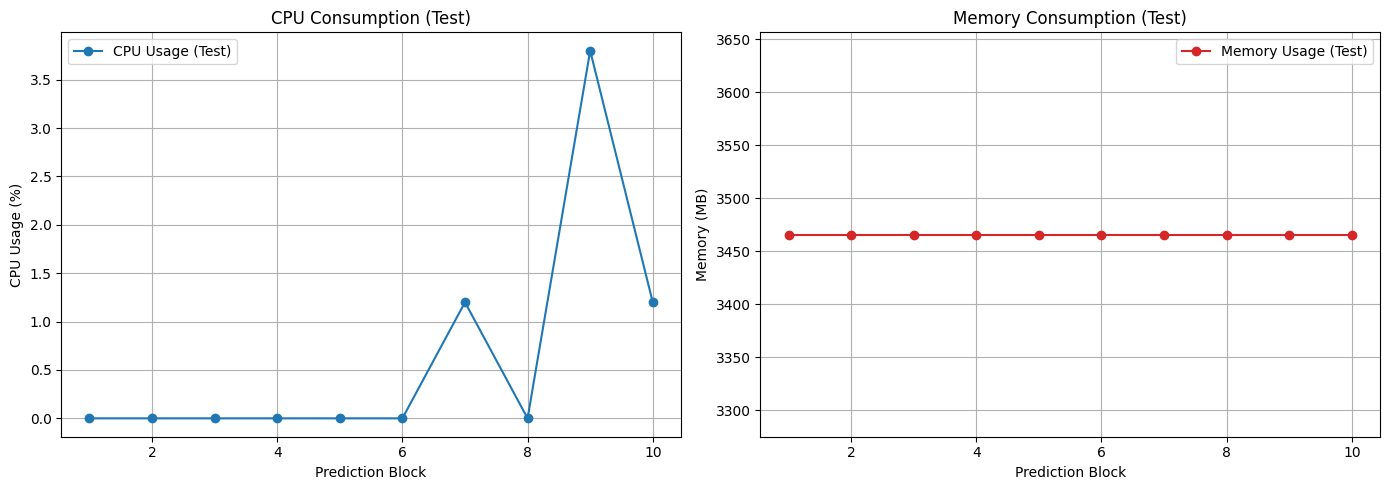


[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 1.38 seconds
Average CPU usage (Test): 14.44%
Average memory usage (Test): 3465.73 MB
Estimated energy consumption: 33131.37 Joules


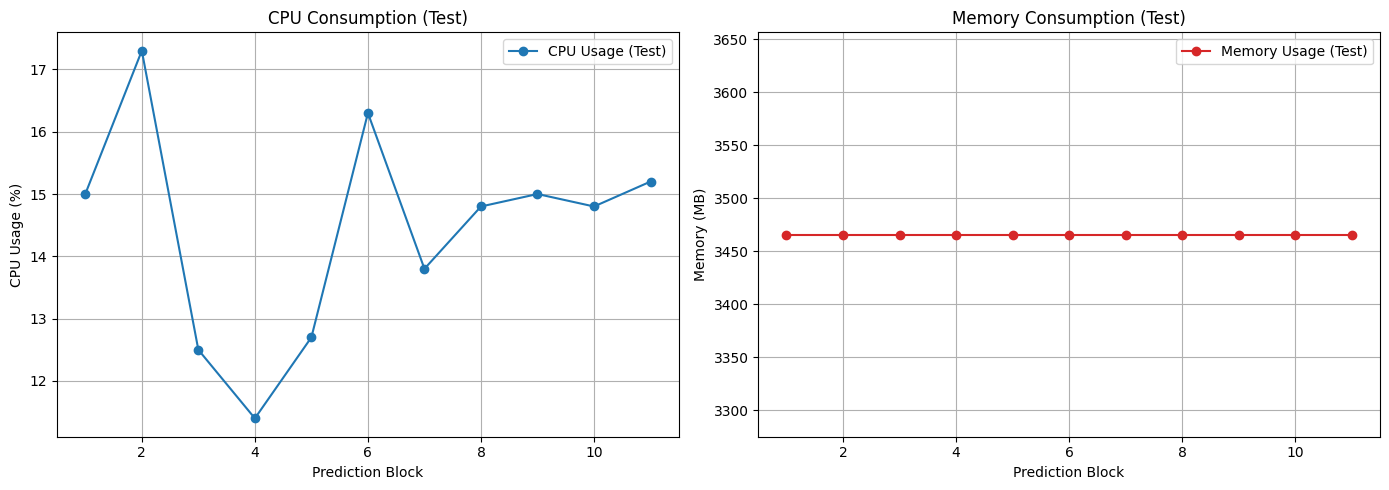

✅ Curva ROC (FULL) gerada para icmp — AUC=0.9950

====== Zero-Day: slowloris ======
Total slowloris no dataset original: 94887
  em X_train antes da remoção: 75934
  em X_test antes: 18953
  moved_to_test (vai mover): 75934
  test_zero (já no teste): 18953
  Zero-Day combined total: 94887 (duplicadas exatas: 684)
  Test full total: 420698

[Início do Treinamento - Random Forest]
[Fim do Treinamento - Random Forest]
Tempo total: 330.17s
CPU média: 50.00%
Memória média: 3255.84 MB
Energia estimada: 3.30e+08 Joules

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 3.44 seconds
Average CPU usage (Test): 0.67%
Average memory usage (Test): 3255.87 MB
Estimated energy consumption: 8.38 Joules


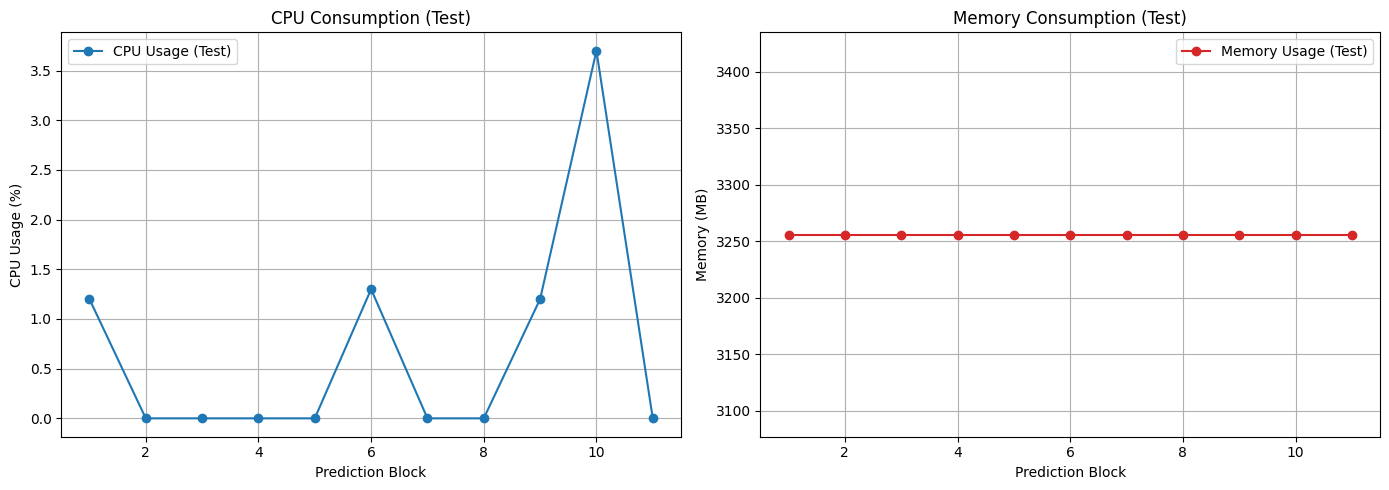


[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 1.67 seconds
Average CPU usage (Test): 1.34%
Average memory usage (Test): 3255.87 MB
Estimated energy consumption: 31.87 Joules


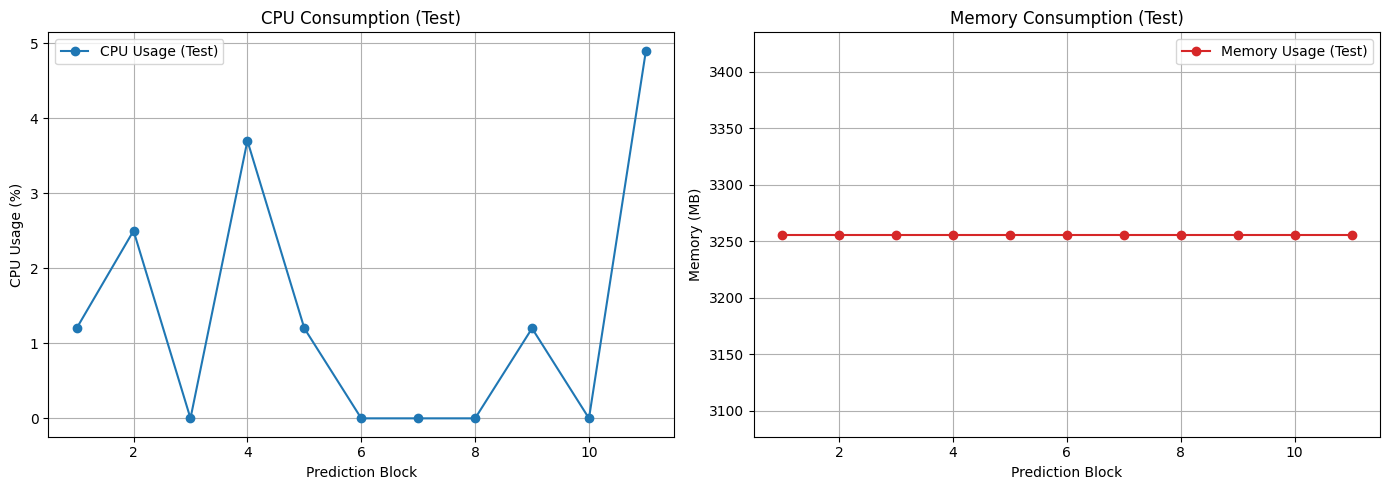

✅ Curva ROC (FULL) gerada para slowloris — AUC=0.9935

====== Zero-Day: udp ======
Total udp no dataset original: 227408
  em X_train antes da remoção: 181655
  em X_test antes: 45753
  moved_to_test (vai mover): 181655
  test_zero (já no teste): 45753
  Zero-Day combined total: 227408 (duplicadas exatas: 1738)
  Test full total: 526419

[Início do Treinamento - Random Forest]
[Fim do Treinamento - Random Forest]
Tempo total: 381.89s
CPU média: 50.00%
Memória média: 3302.55 MB
Energia estimada: 3.82e+08 Joules

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 3.98 seconds
Average CPU usage (Test): 0.45%
Average memory usage (Test): 3302.60 MB
Estimated energy consumption: 2.99 Joules


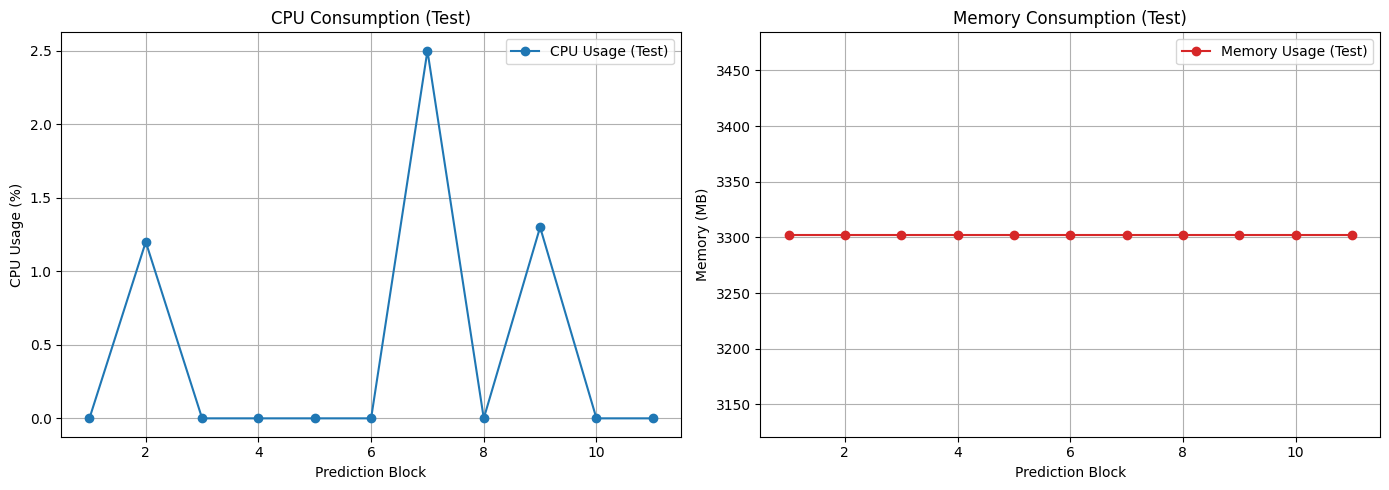


[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 2.33 seconds
Average CPU usage (Test): 0.56%
Average memory usage (Test): 3302.60 MB
Estimated energy consumption: 3.34 Joules


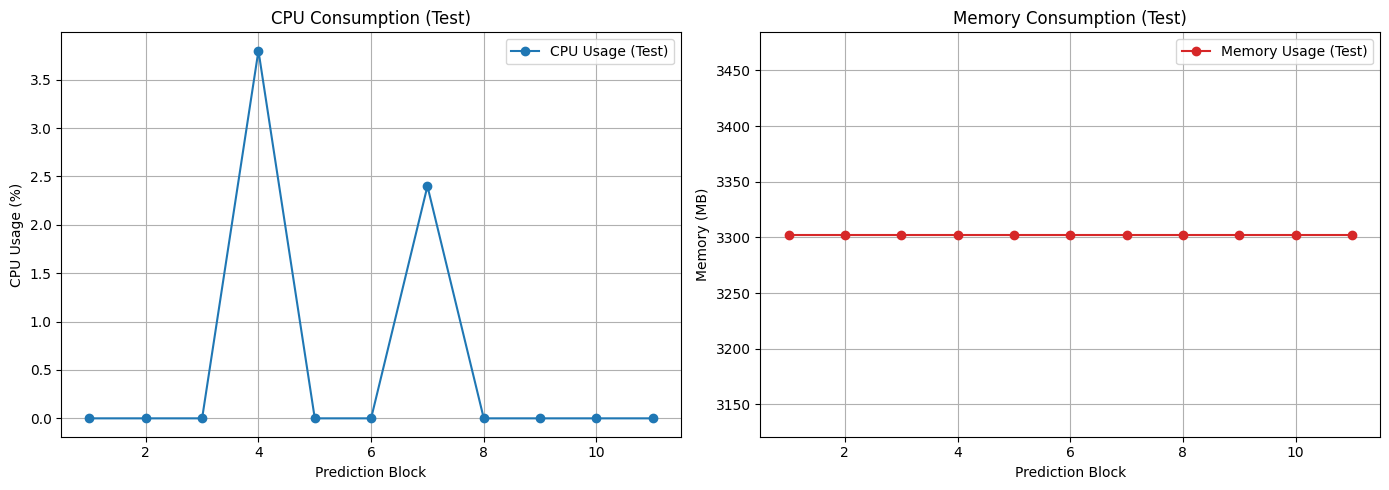

✅ Curva ROC (FULL) gerada para udp — AUC=0.9930

====== Zero-Day: ssh ======
Total ssh no dataset original: 14902
  em X_train antes da remoção: 12009
  em X_test antes: 2893
  moved_to_test (vai mover): 12009
  test_zero (já no teste): 2893
  Zero-Day combined total: 14902 (duplicadas exatas: 187)
  Test full total: 356773

[Início do Treinamento - Random Forest]
[Fim do Treinamento - Random Forest]
Tempo total: 406.12s
CPU média: 50.00%
Memória média: 3494.58 MB
Energia estimada: 4.06e+08 Joules

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 3.14 seconds
Average CPU usage (Test): 0.88%
Average memory usage (Test): 3494.62 MB
Estimated energy consumption: 17.22 Joules


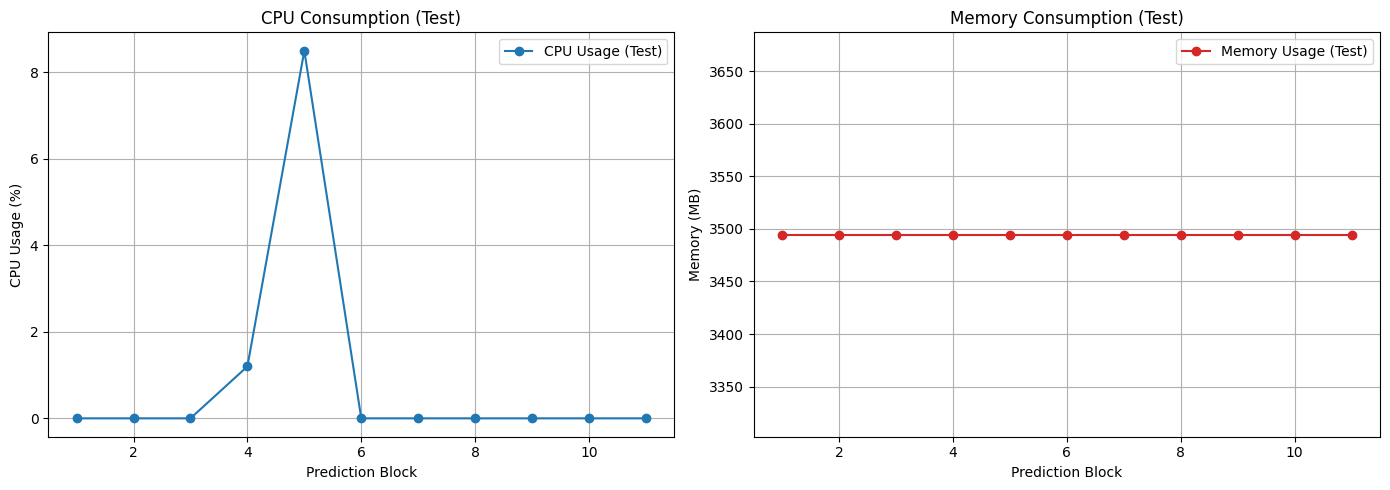


[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 1.31 seconds
Average CPU usage (Test): 0.91%
Average memory usage (Test): 3494.62 MB
Estimated energy consumption: 7.87 Joules


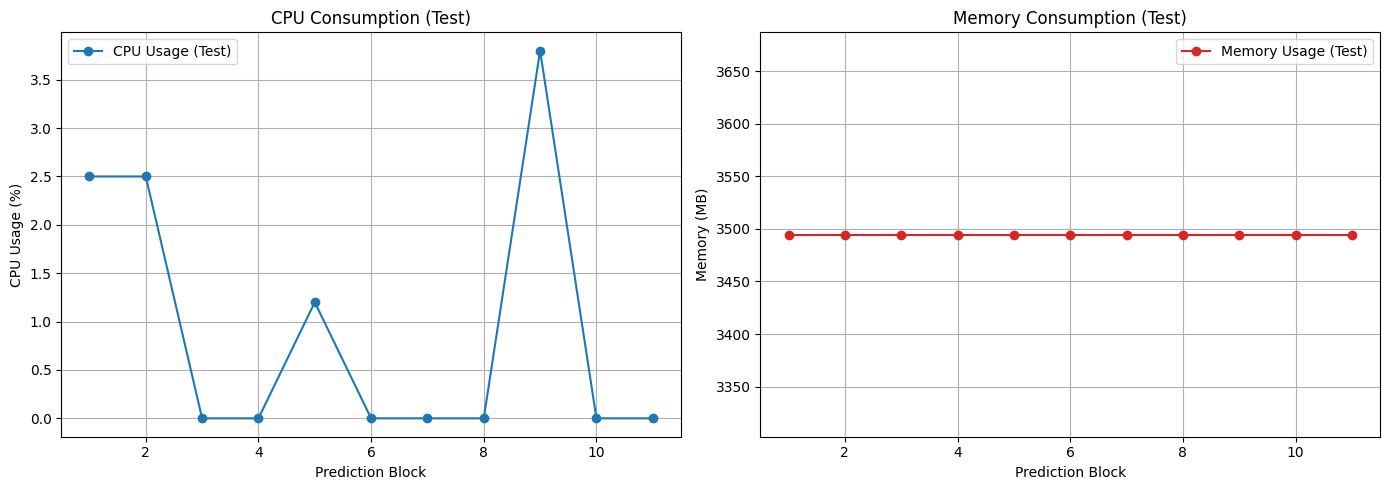

✅ Curva ROC (FULL) gerada para ssh — AUC=0.9931

====== Zero-Day: ftp ======
Total ftp no dataset original: 13664
  em X_train antes da remoção: 10894
  em X_test antes: 2770
  moved_to_test (vai mover): 10894
  test_zero (já no teste): 2770
  Zero-Day combined total: 13664 (duplicadas exatas: 93)
  Test full total: 355658

[Início do Treinamento - Random Forest]
[Fim do Treinamento - Random Forest]
Tempo total: 280.38s
CPU média: 50.00%
Memória média: 3490.89 MB
Energia estimada: 2.80e+08 Joules

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 3.09 seconds
Average CPU usage (Test): 1.03%
Average memory usage (Test): 3490.93 MB
Estimated energy consumption: 26.82 Joules


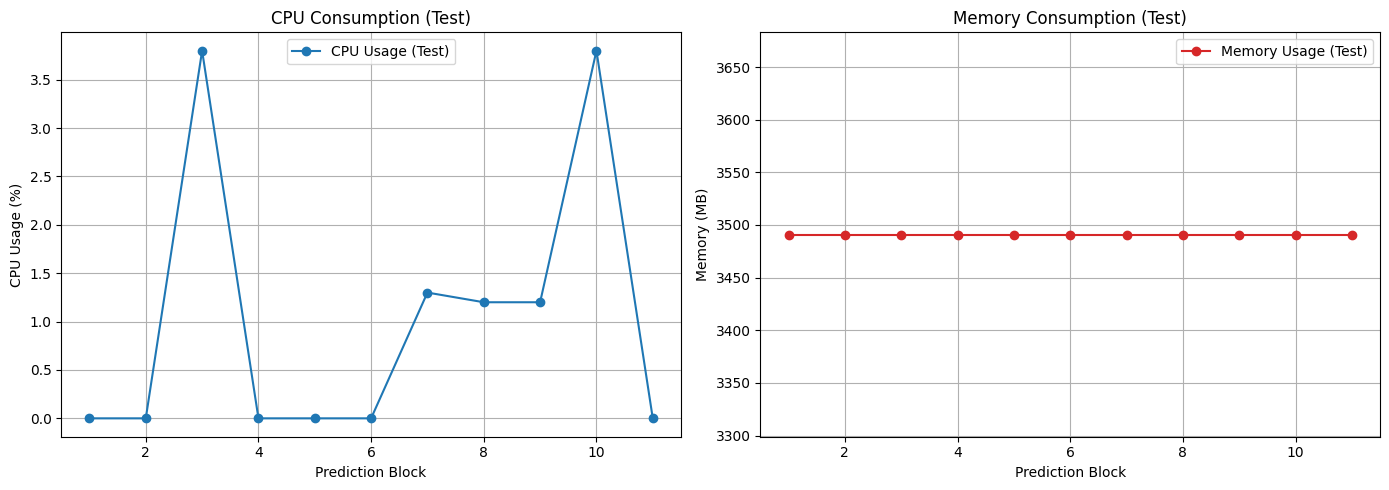


[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 1.29 seconds
Average CPU usage (Test): 14.82%
Average memory usage (Test): 3490.93 MB
Estimated energy consumption: 33464.89 Joules


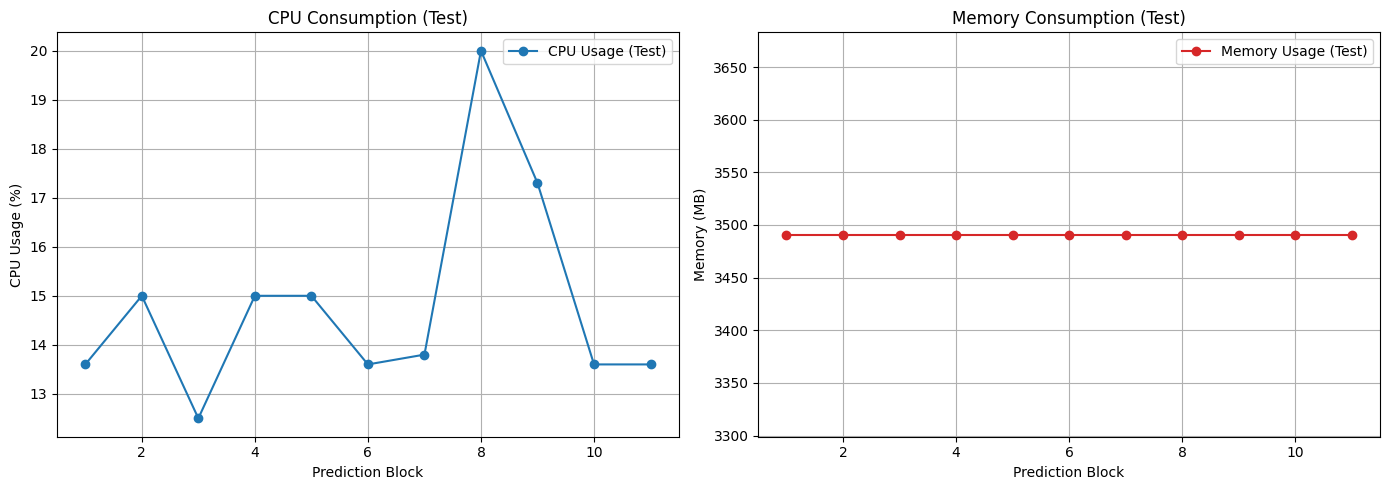

✅ Curva ROC (FULL) gerada para ftp — AUC=0.9950

====== Zero-Day: portscan_tcp ======
Total portscan_tcp no dataset original: 100000
  em X_train antes da remoção: 80192
  em X_test antes: 19808
  moved_to_test (vai mover): 80192
  test_zero (já no teste): 19808
  Zero-Day combined total: 100000 (duplicadas exatas: 17385)
  Test full total: 424956

[Início do Treinamento - Random Forest]
[Fim do Treinamento - Random Forest]
Tempo total: 440.41s
CPU média: 50.00%
Memória média: 3270.53 MB
Energia estimada: 4.40e+08 Joules

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 3.44 seconds
Average CPU usage (Test): 2.96%
Average memory usage (Test): 3270.57 MB
Estimated energy consumption: 716.77 Joules


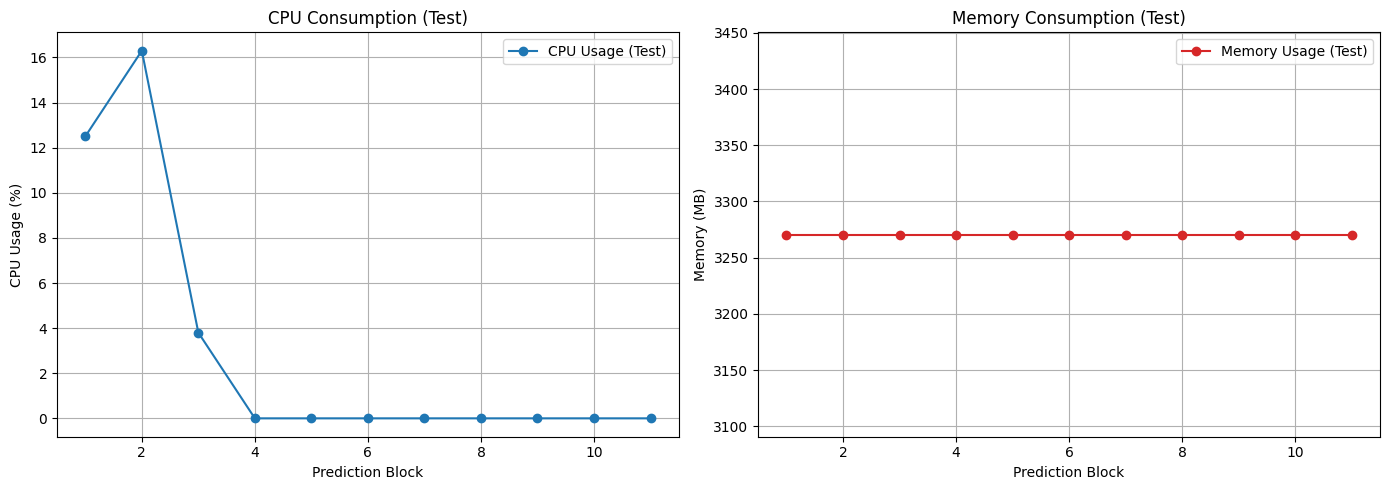


[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 1.55 seconds
Average CPU usage (Test): 0.96%
Average memory usage (Test): 3270.58 MB
Estimated energy consumption: 10.97 Joules


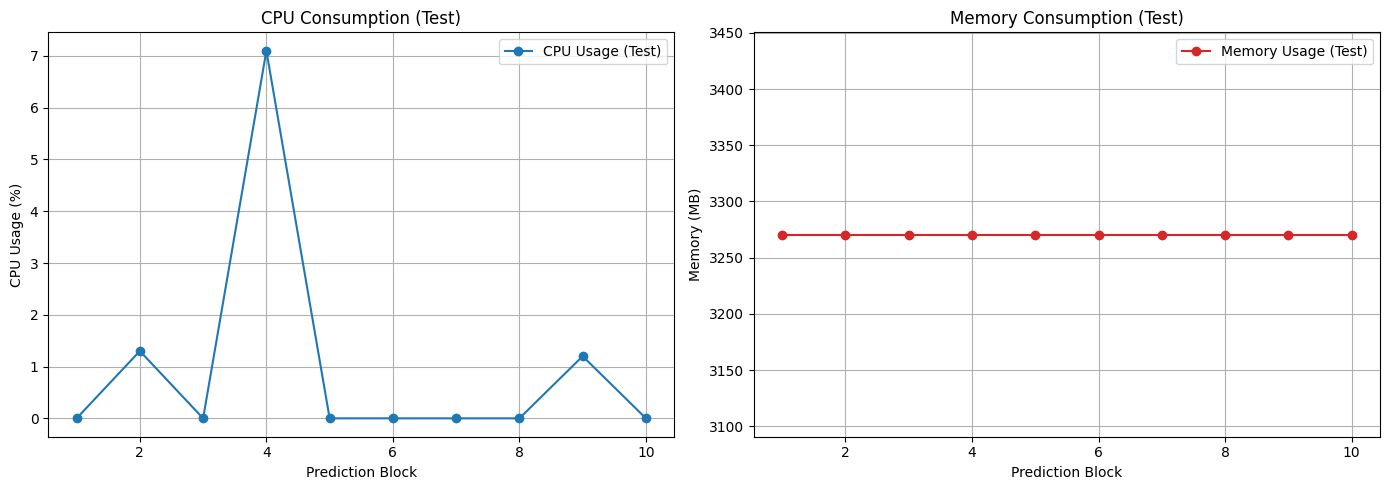

✅ Curva ROC (FULL) gerada para portscan_tcp — AUC=0.9970

====== Zero-Day: os_fingerprinting ======
Total os_fingerprinting no dataset original: 62957
  em X_train antes da remoção: 50265
  em X_test antes: 12692
  moved_to_test (vai mover): 50265
  test_zero (já no teste): 12692
  Zero-Day combined total: 62957 (duplicadas exatas: 145)
  Test full total: 395029

[Início do Treinamento - Random Forest]
[Fim do Treinamento - Random Forest]
Tempo total: 310.71s
CPU média: 50.00%
Memória média: 3492.44 MB
Energia estimada: 3.11e+08 Joules

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 3.29 seconds
Average CPU usage (Test): 7.92%
Average memory usage (Test): 3492.47 MB
Estimated energy consumption: 13073.13 Joules


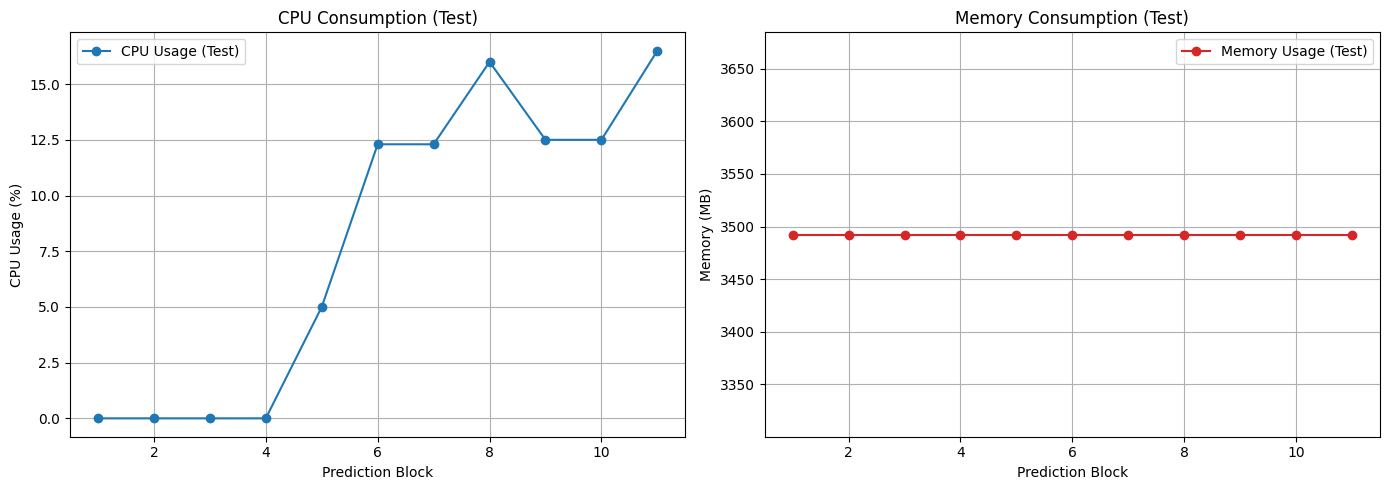


[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 1.48 seconds
Average CPU usage (Test): 1.00%
Average memory usage (Test): 3492.47 MB
Estimated energy consumption: 11.87 Joules


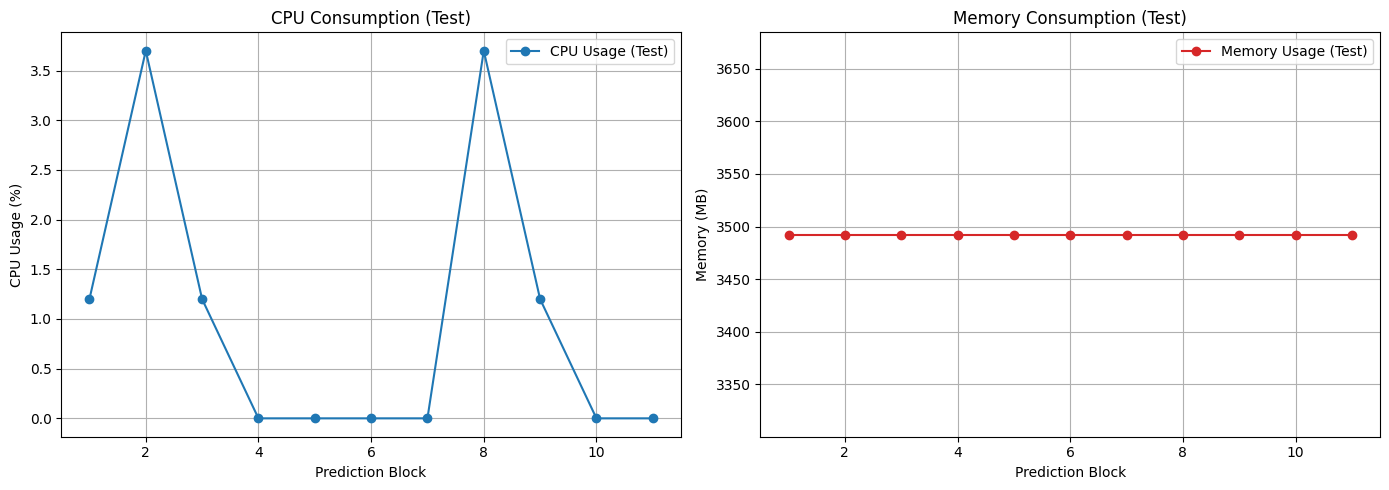

✅ Curva ROC (FULL) gerada para os_fingerprinting — AUC=0.9957

====== Zero-Day: portscan_udp ======
Total portscan_udp no dataset original: 20336
  em X_train antes da remoção: 16281
  em X_test antes: 4055
  moved_to_test (vai mover): 16281
  test_zero (já no teste): 4055
  Zero-Day combined total: 20336 (duplicadas exatas: 15)
  Test full total: 361045

[Início do Treinamento - Random Forest]
[Fim do Treinamento - Random Forest]
Tempo total: 490.56s
CPU média: 50.00%
Memória média: 3251.46 MB
Energia estimada: 4.91e+08 Joules

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 3.12 seconds
Average CPU usage (Test): 0.56%
Average memory usage (Test): 3251.51 MB
Estimated energy consumption: 4.47 Joules


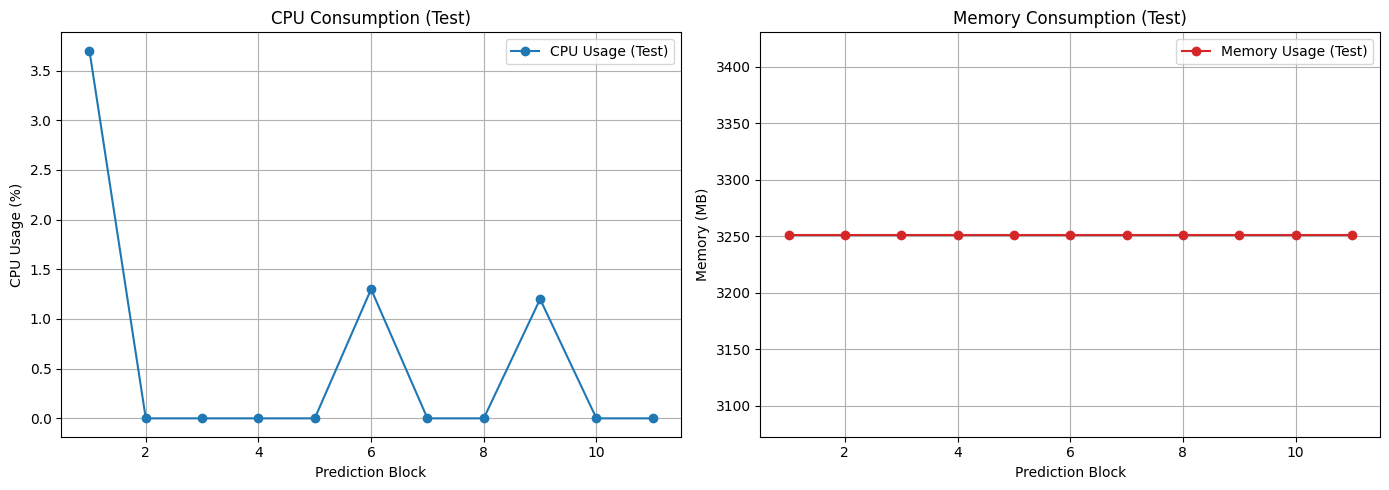


[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 1.29 seconds
Average CPU usage (Test): 11.32%
Average memory usage (Test): 3251.51 MB
Estimated energy consumption: 14925.82 Joules


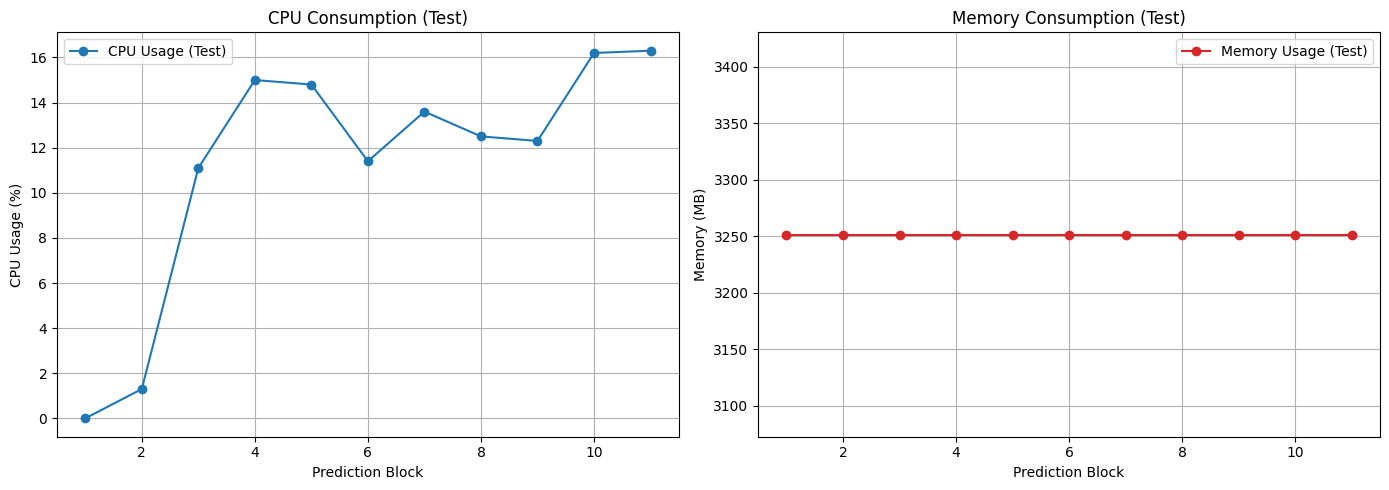

✅ Curva ROC (FULL) gerada para portscan_udp — AUC=0.9957

====== Zero-Day: http_flood ======
Total http_flood no dataset original: 254314
  em X_train antes da remoção: 203559
  em X_test antes: 50755
  moved_to_test (vai mover): 203559
  test_zero (já no teste): 50755
  Zero-Day combined total: 254314 (duplicadas exatas: 905)
  Test full total: 548323

[Início do Treinamento - Random Forest]
[Fim do Treinamento - Random Forest]
Tempo total: 428.22s
CPU média: 50.00%
Memória média: 3430.57 MB
Energia estimada: 4.28e+08 Joules

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 3.68 seconds
Average CPU usage (Test): 0.22%
Average memory usage (Test): 3430.62 MB
Estimated energy consumption: 0.31 Joules


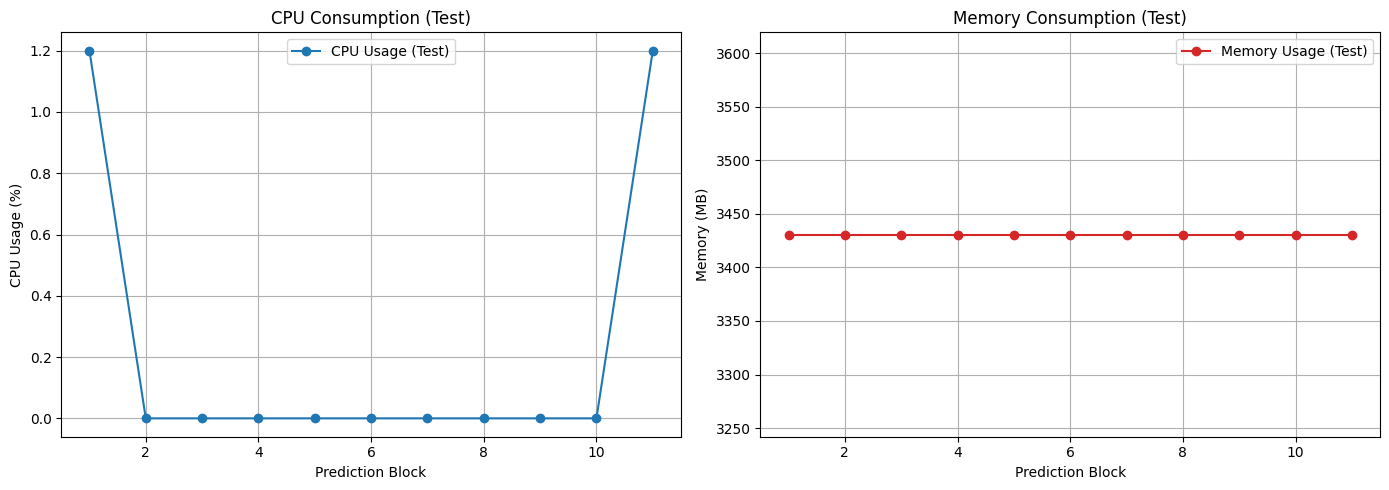


[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 1.95 seconds
Average CPU usage (Test): 14.15%
Average memory usage (Test): 3430.62 MB
Estimated energy consumption: 44257.46 Joules


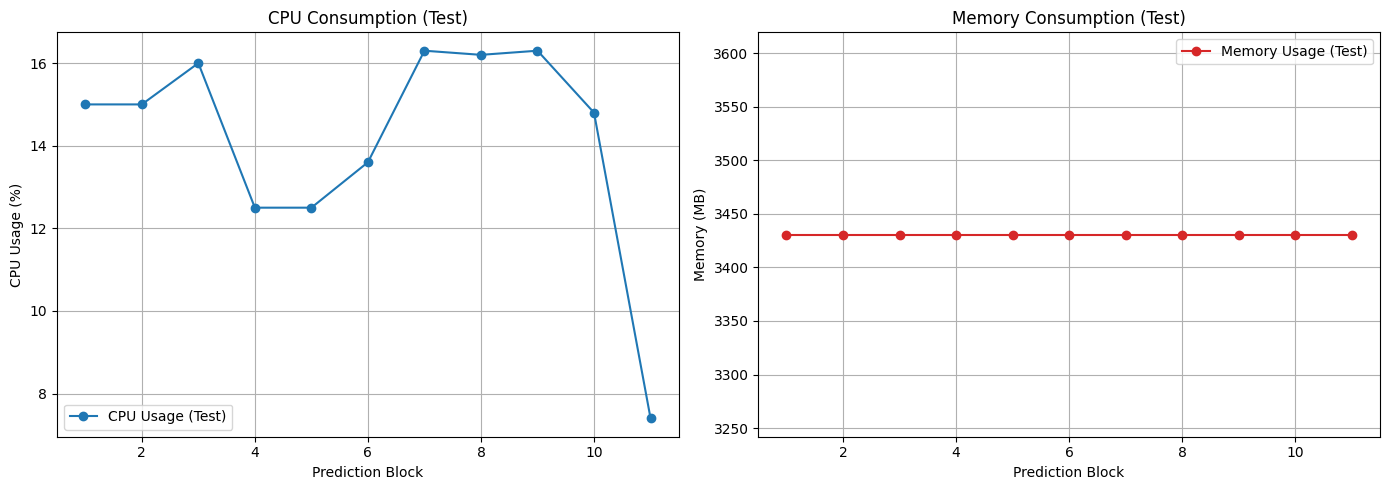

✅ Curva ROC (FULL) gerada para http_flood — AUC=0.9971

====== Zero-Day: dir_bruteforce ======
Total dir_bruteforce no dataset original: 28566
  em X_train antes da remoção: 22843
  em X_test antes: 5723
  moved_to_test (vai mover): 22843
  test_zero (já no teste): 5723
  Zero-Day combined total: 28566 (duplicadas exatas: 79)
  Test full total: 367607

[Início do Treinamento - Random Forest]
[Fim do Treinamento - Random Forest]
Tempo total: 559.39s
CPU média: 50.00%
Memória média: 3265.36 MB
Energia estimada: 5.59e+08 Joules

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 3.26 seconds
Average CPU usage (Test): 9.41%
Average memory usage (Test): 3265.43 MB
Estimated energy consumption: 21749.69 Joules


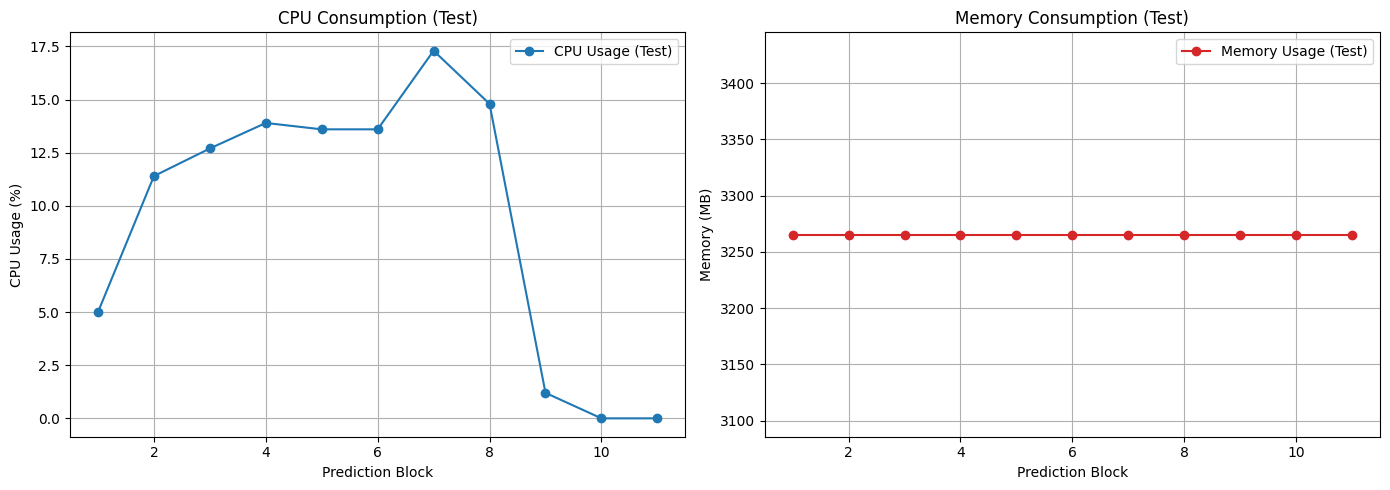


[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 1.32 seconds
Average CPU usage (Test): 1.12%
Average memory usage (Test): 3265.43 MB
Estimated energy consumption: 14.79 Joules


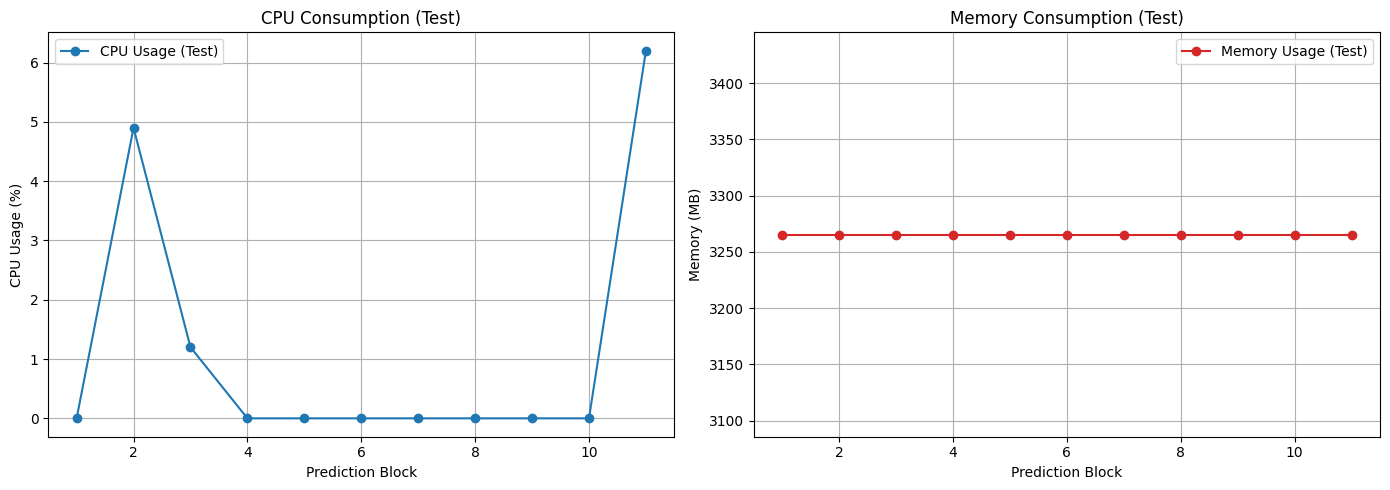

✅ Curva ROC (FULL) gerada para dir_bruteforce — AUC=0.9949

====== Zero-Day: xss ======
Total xss no dataset original: 3661
  em X_train antes da remoção: 2893
  em X_test antes: 768
  moved_to_test (vai mover): 2893
  test_zero (já no teste): 768
  Zero-Day combined total: 3661 (duplicadas exatas: 372)
  Test full total: 347657

[Início do Treinamento - Random Forest]
[Fim do Treinamento - Random Forest]
Tempo total: 574.10s
CPU média: 50.00%
Memória média: 3349.33 MB
Energia estimada: 5.74e+08 Joules

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 3.08 seconds
Average CPU usage (Test): 0.55%
Average memory usage (Test): 3349.40 MB
Estimated energy consumption: 4.20 Joules


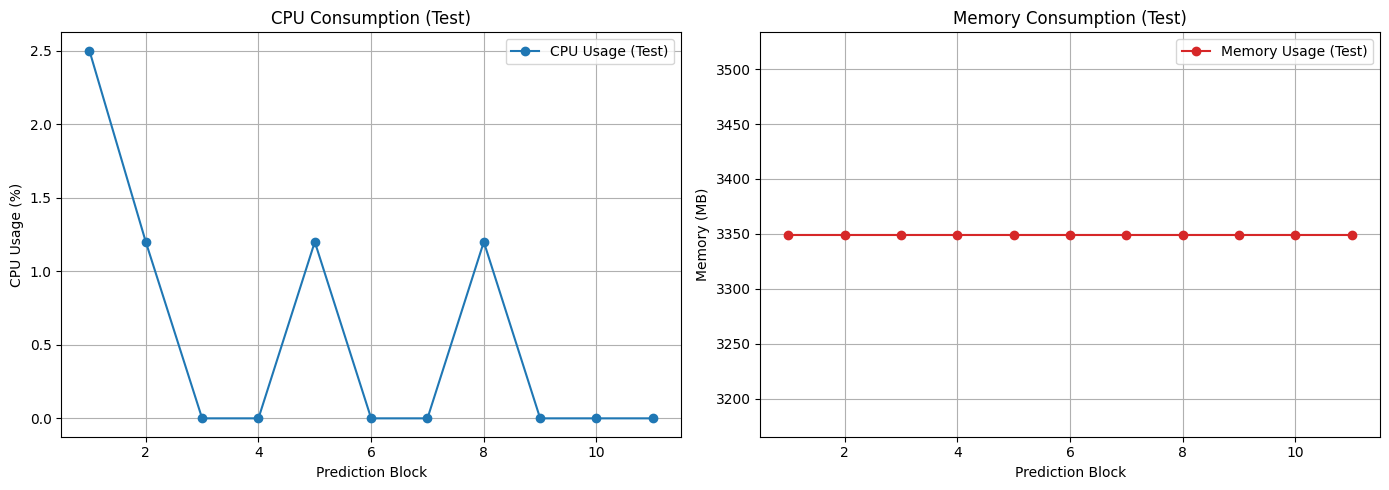


[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 1.23 seconds
Average CPU usage (Test): 2.40%
Average memory usage (Test): 3349.40 MB
Estimated energy consumption: 136.46 Joules


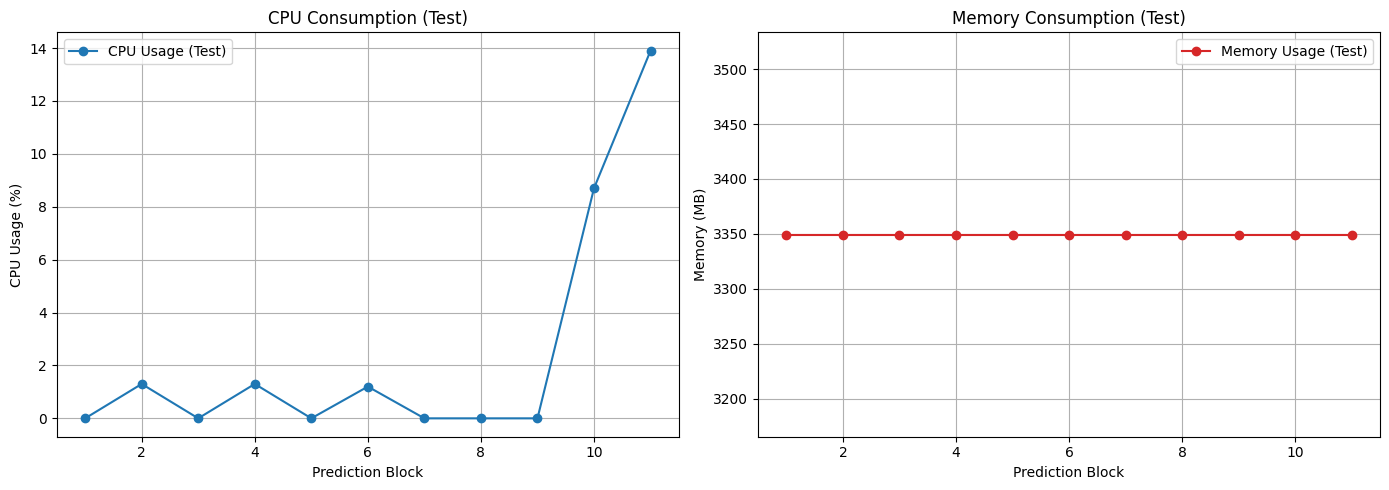

✅ Curva ROC (FULL) gerada para xss — AUC=0.9954

====== Zero-Day: sql_injection ======
Total sql_injection no dataset original: 1763
  em X_train antes da remoção: 1427
  em X_test antes: 336
  moved_to_test (vai mover): 1427
  test_zero (já no teste): 336
  Zero-Day combined total: 1763 (duplicadas exatas: 478)
  Test full total: 346191

[Início do Treinamento - Random Forest]
[Fim do Treinamento - Random Forest]
Tempo total: 570.82s
CPU média: 50.00%
Memória média: 3463.62 MB
Energia estimada: 5.71e+08 Joules

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 3.09 seconds
Average CPU usage (Test): 5.64%
Average memory usage (Test): 3463.68 MB
Estimated energy consumption: 4428.42 Joules


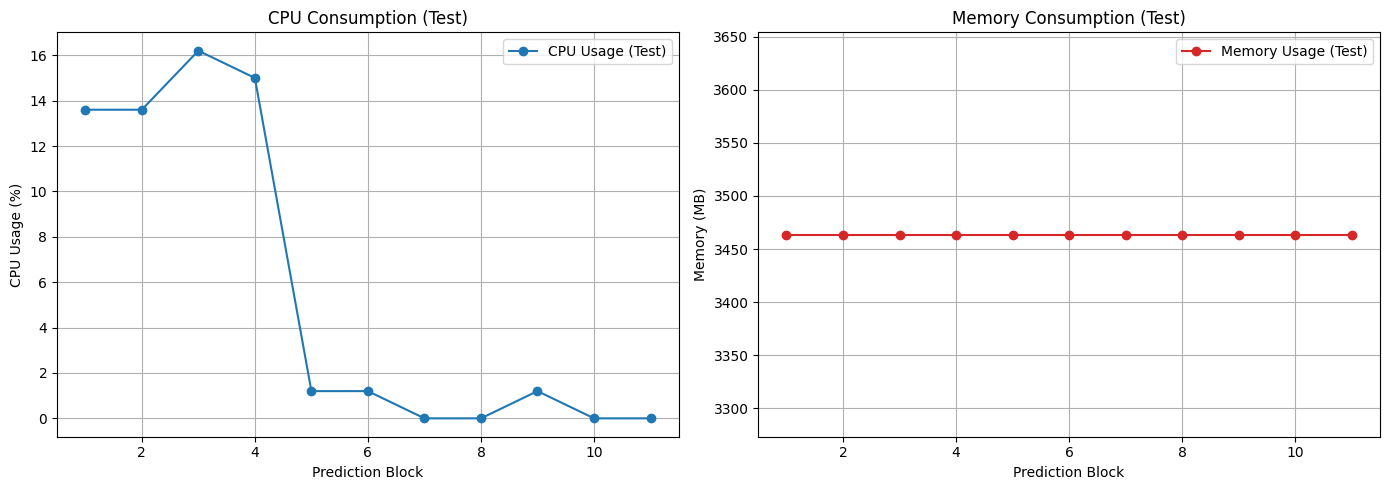


[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 1.21 seconds
Average CPU usage (Test): 0.68%
Average memory usage (Test): 3463.68 MB
Estimated energy consumption: 3.06 Joules


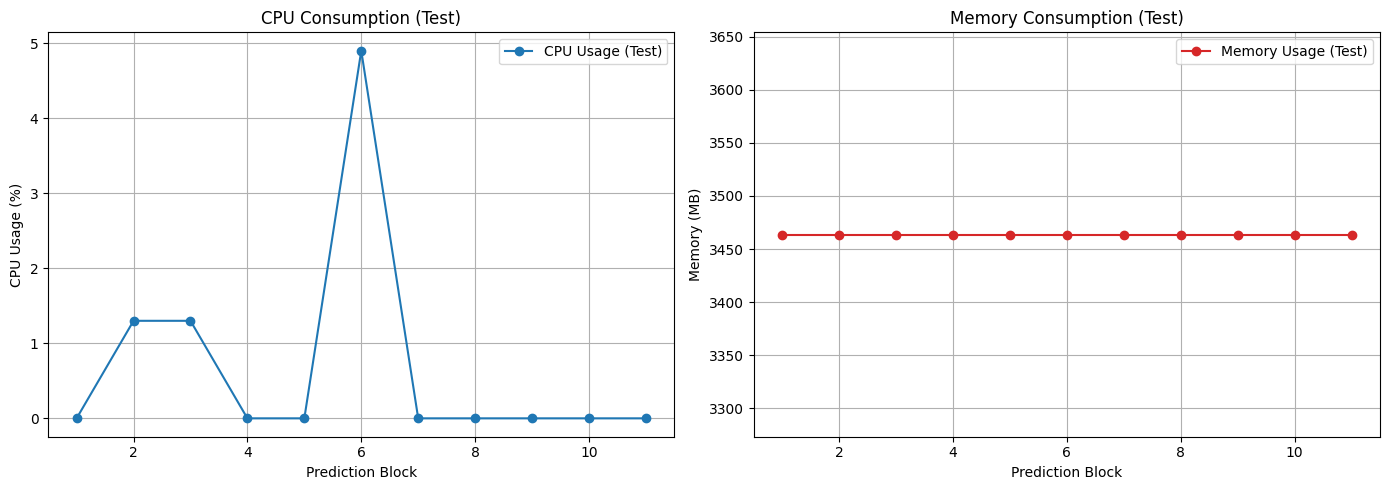

✅ Curva ROC (FULL) gerada para sql_injection — AUC=0.9960


In [ ]:
# ===== IMPORTS =====
import pandas as pd
import numpy as np
import time
import psutil
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import os


# Configuração das features e rótulos
features = [
    'src_port', 'dst_port', 'duration', 'src_bytes', 'dst_bytes', 'missed_bytes',
    'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'ip_proto',
    'http_trans_depth', 'files_total_bytes', 'is_GET_mthd',
    'http_status_error', 'is_file_transfered', 'attack_type'
]

X = encoded[features]
y = encoded['Label']  # Coluna de rótulos

# Dividir antes de escolher zero-days
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Guardar Attack Type para separar os zero-days
X_train['attack_type'] = encoded.loc[X_train.index, 'attack_type']
X_test['attack_type'] = encoded.loc[X_test.index, 'attack_type']

# ===== CONFIGURAÇÕES =====
zero_day_attacks = ['tcp_ack', 'syn', 'icmp', 'slowloris', 'udp', 'ssh', 'ftp', 'portscan_tcp', 'os_fingerprinting', 'portscan_udp', 'http_flood', 'dir_bruteforce', 'xss', 'sql_injection']  # Adapte para os ataques que você quiser testar
smote = SMOTE(random_state=42)
scaler = StandardScaler()
label_encoder = LabelEncoder()

resultados_zero_day = []

model_name = "RandomForest"
roc_full_curves = []

# ===== LOOP PRINCIPAL =====
for ataque_zero_day in zero_day_attacks:
    print(f"\n====== Zero-Day: {ataque_zero_day} ======")

    # contagem global no dataset original (só pra referência)
    total_in_original = (X['attack_type'] == ataque_zero_day).sum()
    print(f"Total {ataque_zero_day} no dataset original: {total_in_original}")

    # --- Separação dos dados ---
    train_indices = X_train[X_train['attack_type'] != ataque_zero_day].index
    test_indices = X_test[X_test['attack_type'] == ataque_zero_day].index

    # --- Amostras zero-day que estavam originalmente no treino (vai mover para o teste) ---
    moved_to_test = X_train.loc[X_train['attack_type'] == ataque_zero_day].copy()
    moved_to_test_y = y_train.loc[moved_to_test.index].copy()

    # debug counts
    n_train_zero = len(moved_to_test)
    n_test_zero = len(test_indices)
    n_train_before = (X_train['attack_type'] == ataque_zero_day).sum()
    n_test_before = (X_test['attack_type'] == ataque_zero_day).sum()
    print(f"  em X_train antes da remoção: {n_train_before}")
    print(f"  em X_test antes: {n_test_before}")
    print(f"  moved_to_test (vai mover): {n_train_zero}")
    print(f"  test_zero (já no teste): {n_test_zero}")

    # --- Conjuntos limpos (sem o ataque zero-day no treino) ---
    X_train_clean = X_train.loc[train_indices].drop(columns=['attack_type']).copy()
    y_train_clean = y_train.loc[train_indices].copy()

    # --- Teste zero-day: inclui amostras do teste original + as movidas do treino ---
    X_test_zero_day = pd.concat([
        X_test.loc[test_indices].drop(columns=['attack_type']).copy(),
        moved_to_test.drop(columns=['attack_type']).copy()
    ], ignore_index=True)  # reset index para evitar sobreposição
    y_test_zero_day = pd.concat([
        y_test.loc[test_indices].copy(),
        moved_to_test_y.copy()
    ], ignore_index=True)

    # --- Teste completo: todo o X_test original + as amostras movidas do treino ---
    X_test_full = pd.concat([
        X_test.drop(columns=['attack_type']).copy(),
        moved_to_test.drop(columns=['attack_type']).copy()
    ], ignore_index=True)
    y_test_full = pd.concat([
        y_test.copy().reset_index(drop=True),
        moved_to_test_y.copy().reset_index(drop=True)
    ], ignore_index=True)

    # checar duplicatas exatas (linhas idênticas) no conjunto zero-day
    n_dupes = X_test_zero_day.duplicated().sum()
    print(f"  Zero-Day combined total: {len(X_test_zero_day)} (duplicadas exatas: {n_dupes})")
    print(f"  Test full total: {len(X_test_full)}")

    # extra debug: se houver muito mais que o total original, alerta
    if len(X_test_zero_day) > total_in_original:
        print(f"[WARNING] mais amostras zero-day no teste ({len(X_test_zero_day)}) do que no dataset original ({total_in_original}). Verifique possíveis fontes de duplicação ou rótulos desiguais.")


    # --- Balanceamento com SMOTE ---
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_clean, y_train_clean)

    # --- Normalização ---
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_full_scaled = scaler.transform(X_test_full)
    X_test_zero_day_scaled = scaler.transform(X_test_zero_day)

    # =============================
    # Codificação dos rótulos
    # =============================
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train_balanced)
    y_test_full_encoded = le.transform(y_test_full)
    y_test_zero_day_encoded = le.transform(y_test_zero_day)

    # =============================
    # Treinamento do modelo
    # =============================

    model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

    recursos_rf = monitor_train_generic(model, X_train_scaled, y_train_encoded, "Random Forest")

    model.fit(X_train_scaled, y_train_encoded)

    # =============================
    # TESTE GERAL COM MONITORAMENTO
    # =============================
    mstart_time = time.time()
    y_pred_full = model.predict(X_test_full_scaled)
    y_pred_full_encoded = le.transform(y_pred_full)
    metrics_test_full = monitor_test_prediction(model, X_test_full_scaled)
    acc_teste_full = accuracy_score(y_test_full_encoded, y_pred_full_encoded)
    f1_teste_full = f1_score(y_test_full_encoded, y_pred_full_encoded, zero_division=1)
    precision_full = precision_score(y_test_full_encoded, y_pred_full_encoded, zero_division=1)
    recall_full = recall_score(y_test_full_encoded, y_pred_full_encoded, zero_division=1)


    # =============================
    # TESTE ZERO-DAY COM MONITORAMENTO
    # =============================
    start_time = time.time()
    y_pred_zero_day = model.predict(X_test_zero_day_scaled)
    y_pred_zero_day_encoded = le.transform(y_pred_zero_day)
    metrics_zero_day = monitor_test_prediction(model, X_test_zero_day_scaled)
    acc_zero_day = accuracy_score(y_test_zero_day_encoded, y_pred_zero_day_encoded)
    f1_zero_day = f1_score(y_test_zero_day_encoded, y_pred_zero_day_encoded, zero_division=1)
    precision_zero = precision_score(y_test_zero_day_encoded, y_pred_zero_day_encoded, zero_division=1)
    recall_zero = recall_score(y_test_zero_day_encoded, y_pred_zero_day_encoded, zero_division=1)

    # =============================
    # Salvar resultados
    # =============================
    resultados_zero_day.append({
    'Ataque Zero-Day': ataque_zero_day,

    'Acurácia': acc_teste_full,
    'F1': f1_teste_full,
    'Precision': precision_full,
    'Recall': recall_full,
    'Tempo de Teste': metrics_test_full['total_time'],
    'CPU Teste': metrics_test_full['avg_cpu'],
    'Memória Teste': metrics_test_full['avg_mem'],
    'Energia Teste': metrics_test_full['energia'],

    'ZD - Acurácia': acc_zero_day,
    'ZD- F1': f1_zero_day,
    'ZD - Precision': precision_zero,
    'ZD - Recall': recall_zero,
    'ZD - Tempo de Teste': metrics_zero_day['total_time'],
    'ZD - CPU Teste': metrics_zero_day['avg_cpu'],
    'ZD - Memória Teste': metrics_zero_day['avg_mem'],
    'ZD - Energia Teste': metrics_zero_day['energia'],
})
    # =============================
    # CURVA ROC (gerada no mesmo loop)
    # =============================
    # TESTE FULL
    if hasattr(model, "predict_proba"):
        probs_full = model.predict_proba(X_test_full_scaled)[:, 1]
    elif hasattr(model, "decision_function"):
        probs_full = model.decision_function(X_test_full_scaled)
    else:
        raise AttributeError(f"O modelo {model.__class__.__name__} não possui predict_proba nem decision_function.")

    fpr_full, tpr_full, _ = roc_curve(y_test_full_encoded, probs_full)
    roc_auc_full = auc(fpr_full, tpr_full)

    # Guarda a curva na lista (com label do ataque)
    roc_full_curves.append((fpr_full, tpr_full, roc_auc_full, f"{ataque_zero_day}"))

    print(f"✅ Curva ROC (FULL) gerada para {ataque_zero_day} — AUC={roc_auc_full:.4f}")

    del model
    gc.collect()
    K.clear_session()

/tmp/ipython-input-1070250525.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(roc_full_curves))


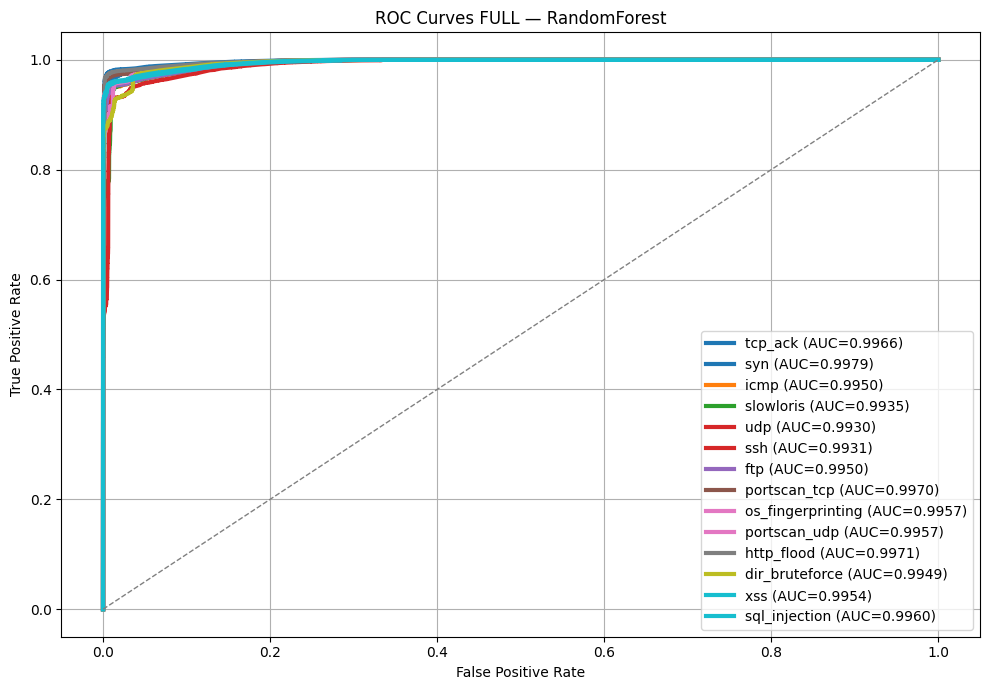

In [ ]:
# =========================================
# Após o loop, gera um gráfico com todas as curvas FULL
# =========================================
plt.figure(figsize=(10, 7))
colors = plt.cm.get_cmap('tab10', len(roc_full_curves))

for i, (fpr, tpr, auc_val, label) in enumerate(roc_full_curves):
    plt.plot(fpr, tpr, lw=3, color=colors(i), label=f"{label} (AUC={auc_val:.4f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves FULL — {model_name}')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
os.makedirs("roc_curves", exist_ok=True)
plt.savefig(f"roc_curves/{model_name}_ALL_FULL_ROC.png", dpi=400)
plt.show()

In [ ]:
!pip install tabulate

In [ ]:
import pandas as pd
from tabulate import tabulate

df_resultados = pd.DataFrame(resultados_zero_day)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 180)
pd.set_option('display.float_format', '{:.4f}'.format)

print(tabulate(df_resultados, headers='keys', tablefmt='fancy_grid', showindex=False))

╒═══════════════════╤════════════╤══════════╤═════════════╤══════════╤══════════════════╤═════════════╤═════════════════╤═════════════════╤═════════════════╤══════════╤══════════════════╤═══════════════╤═══════════════════════╤══════════════════╤══════════════════════╤══════════════════════╕
│ Ataque Zero-Day   │   Acurácia │       F1 │   Precision │   Recall │   Tempo de Teste │   CPU Teste │   Memória Teste │   Energia Teste │   ZD - Acurácia │   ZD- F1 │   ZD - Precision │   ZD - Recall │   ZD - Tempo de Teste │   ZD - CPU Teste │   ZD - Memória Teste │   ZD - Energia Teste │
╞═══════════════════╪════════════╪══════════╪═════════════╪══════════╪══════════════════╪═════════════╪═════════════════╪═════════════════╪═════════════════╪══════════╪══════════════════╪═══════════════╪═══════════════════════╪══════════════════╪══════════════════════╪══════════════════════╡
│ tcp_ack           │   0.964812 │ 0.980771 │    0.999285 │ 0.962931 │          3.78882 │    0.454545 │         2993.79 │

In [ ]:
df_resultados.to_csv('resultados_zero_day_formatado.csv', index=False, float_format='%.4f')